# Python: Hyperparametertuning with Optuna

This notebook explains how to use the implmented `tune_ml_models()` method to tune hyperparameters using the [Optuna](https://optuna.org/) package.

In this example, we will focus on the [DoubleMLAPO](https://docs.doubleml.org/stable/api/generated/doubleml.irm.DoubleMLAPO.html#doubleml.irm.DoubleMLAPO) model to estimate average potential outcomes (APOs) in an interactive regression model (see [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#binary-interactive-regression-model-irm)).

The goal is to estimate the average potential outcome

 $$\theta_0 =\mathbb{E}[Y(d)]$$

for a given treatment level $d$ and and discrete valued treatment $D$.

For a more detailed description of the DoubleMLAPO model, see [Average Potential Outcome Model](https://docs.doubleml.org/stable/guide/models.html#average-potential-outcomes-apos) or [Example Gallery](https://docs.doubleml.org/stable/examples/index.html).

**Remark** that the untuned settings and hyperparameter spaces are mainly chosen for display of the tuning possibilities and not a blueprint for standard tuning.

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.io import show

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import StackingRegressor, StackingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

from doubleml.data import DoubleMLData
from doubleml.irm import DoubleMLAPO, DoubleMLAPOS
from doubleml.irm.datasets import make_irm_data_discrete_treatments

palette = sns.color_palette("colorblind")

import warnings
warnings.filterwarnings("ignore")

## Data Generating Process (DGP)

At first, let us generate data according to the [make_irm_data_discrete_treatments](https://docs.doubleml.org/dev/api/datasets.html#dataset-generators) data generating process. The process generates data with a continuous treatment variable and contains the true individual treatment effects (ITEs) with respect to option of not getting treated.

According to the continuous treatment variable, the treatment is discretized into multiple levels, based on quantiles. Using the *oracle* ITEs, enables the comparison to the true APOs and averate treatment effects (ATEs) for the different levels of the treatment variable.

**Remark:** The average potential outcome model does not require an underlying continuous treatment variable. The model will work identically if the treatment variable is discrete by design.

In [2]:
# Parameters
n_obs = 500
n_levels = 3
treatment_lvl = 1.0

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=False)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average Individual effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average Potential Outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average Individual effects in each group:
[ 0.    3.44  9.32 10.49]

Average Potential Outcomes in each group:
[210.05 213.49 219.38 220.54]

Levels and their counts:
(array([0., 1., 2., 3.]), array([171, 110, 109, 110]))


As for all [DoubleML](https://docs.doubleml.org/stable/index.html) models, we specify a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.data.DoubleMLData.html) object to handle the data.

In [3]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 27.5 KB



## Basic Tuning Example

At first, we will take a look at a very basic tuning example without much customization.

### Define Nuisance Learners

For our example, we will choose [LightGBM](https://lightgbm.readthedocs.io/en/stable/) learners, which are typical non-parametric choice.

In [4]:
ml_g = LGBMRegressor(random_state=314, verbose=-1)
ml_m = LGBMClassifier(random_state=314, verbose=-1)

### Untuned Model

Now let us take a look at the standard workflow, focusing on a single treatment level and using default hyperparameters.

In [5]:
dml_obj_untuned = DoubleMLAPO(
    dml_data,
    ml_g,
    ml_m,
    treatment_level=treatment_lvl,
)

dml_obj_untuned.fit()
dml_obj_untuned.summary

coef    std err          t         P>|t|       2.5 %      97.5 %
d  211.232659  15.657431  13.490888  1.769555e-41  180.544657  241.920661

### Hyperparameter Tuning

Now, let us take a look at the basic hyperparameter tuning. We will initialize a separate model to compare the results.

In [6]:
dml_obj_tuned = DoubleMLAPO(
    dml_data,
    ml_g,
    ml_m,
    treatment_level=treatment_lvl,
)

The required input for tuning is a parameter space dictionary for the hyperparameters for each learner that should be tuned.
This dictionary should include a callable for each learner you want to have (only a subset is also possible, i.e. only tuning `ml_g`).

The parameter spaces should be a callable and suggest the search spaces via a `trial` object.

Generally, the hyperparameter structure should follow the definitions in [Optuna](https://optuna.org/#key_features), but instead of the objective the hyperparameters have to be specified as a callable. The corresponding DoubleML object then assigns a corresponding objective for each learning using the supplied parameter space.

To keep this example relatively fast and simple, we keep the `n_estimators` fix and only tune a small number of other hyperparameters.

In [7]:
# parameter space for the outcome regression tuning
def ml_g_params(trial):
    return {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': 5,
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50, step=10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 10.0, log=True),
    }

# parameter space for the propensity score tuning
def ml_m_params(trial):
    return {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': 5,
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50, step=10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 10.0, log=True),
    }

param_space = {
    'ml_g': ml_g_params,
    'ml_m': ml_m_params
}

To tune the hyperparameters the `tune_ml_models()` with the `ml_param_space` argument should be called.
Further, to define the number of trials and other optuna options you can use the `optuna_setttings` argument.

In [8]:
optuna_settings = {
    'n_trials': 200,
    'show_progress_bar': True,
    'verbosity': optuna.logging.WARNING,  # Suppress Optuna logs
}

dml_obj_tuned.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Per default, the model will set the best hyperparameters automatically (identical hyperparameters for each fold), and you can directly call the `fit()` method afterwards.

In [9]:
dml_obj_tuned.fit()
dml_obj_tuned.summary

coef  std err         t  P>|t|       2.5 %      97.5 %
d  215.273433    2.485  86.62916    0.0  210.402924  220.143943

**Remark**: Even if the initialization and tuning only requires the learners `ml_g` and `ml_m`, the models in the `irm` submodule generally, copy the learner for `ml_g` and fit different response surfaces for treatment and control (or not-treatment) groups. These different learners are tuned separately but with the same parameter space. To see which parameter spaces can be tuned you can take a look at the `params_names` property.

In this example, we specified the parameter spaces for `ml_m` and `ml_g`, but actually three sets of hyperparameters were tuned, i.e. `ml_m`, `ml_g_d_lvl0` and `ml_g_d_lvl1` (two response surfaces for the outcome).

In [10]:
dml_obj_tuned.params_names

['ml_g_d_lvl0', 'ml_g_d_lvl1', 'ml_m']

Each hyperparameter combination is set for each fold.

In [11]:
dml_obj_tuned.params

{'ml_g_d_lvl0': {'d': [[{'learning_rate': 0.09801463544687879,
     'min_child_samples': 20,
     'lambda_l1': 3.1247297280098136,
     'lambda_l2': 0.1676705013704926},
    {'learning_rate': 0.09801463544687879,
     'min_child_samples': 20,
     'lambda_l1': 3.1247297280098136,
     'lambda_l2': 0.1676705013704926},
    {'learning_rate': 0.09801463544687879,
     'min_child_samples': 20,
     'lambda_l1': 3.1247297280098136,
     'lambda_l2': 0.1676705013704926},
    {'learning_rate': 0.09801463544687879,
     'min_child_samples': 20,
     'lambda_l1': 3.1247297280098136,
     'lambda_l2': 0.1676705013704926},
    {'learning_rate': 0.09801463544687879,
     'min_child_samples': 20,
     'lambda_l1': 3.1247297280098136,
     'lambda_l2': 0.1676705013704926}]]},
 'ml_g_d_lvl1': {'d': [[{'learning_rate': 0.09957868943595276,
     'min_child_samples': 20,
     'lambda_l1': 1.0312190390696285,
     'lambda_l2': 0.058903541934281406},
    {'learning_rate': 0.09957868943595276,
     'min_ch

### Comparison
 
Let us compare the results for both models. If we take a look at the predictive performance of the learners, the main difference can be observed in the log loss of the propensity score `ml_m`

In [12]:
dml_obj_untuned.evaluate_learners()

{'ml_g_d_lvl0': array([[14.49934441]]),
 'ml_g_d_lvl1': array([[23.50828321]]),
 'ml_m': array([[0.44349955]])}

In [13]:
dml_obj_tuned.evaluate_learners()

{'ml_g_d_lvl0': array([[14.73579164]]),
 'ml_g_d_lvl1': array([[23.25821083]]),
 'ml_m': array([[0.4101895]])}

As a result the standard error is reduced and confidence intervals are much tighter.


True APO at treatment level 1.0: 213.4904

  Model      theta        se   ci_lower   ci_upper
Untuned 211.232659 15.657431 180.544657 241.920661
  Tuned 215.273433  2.485000 210.402924 220.143943


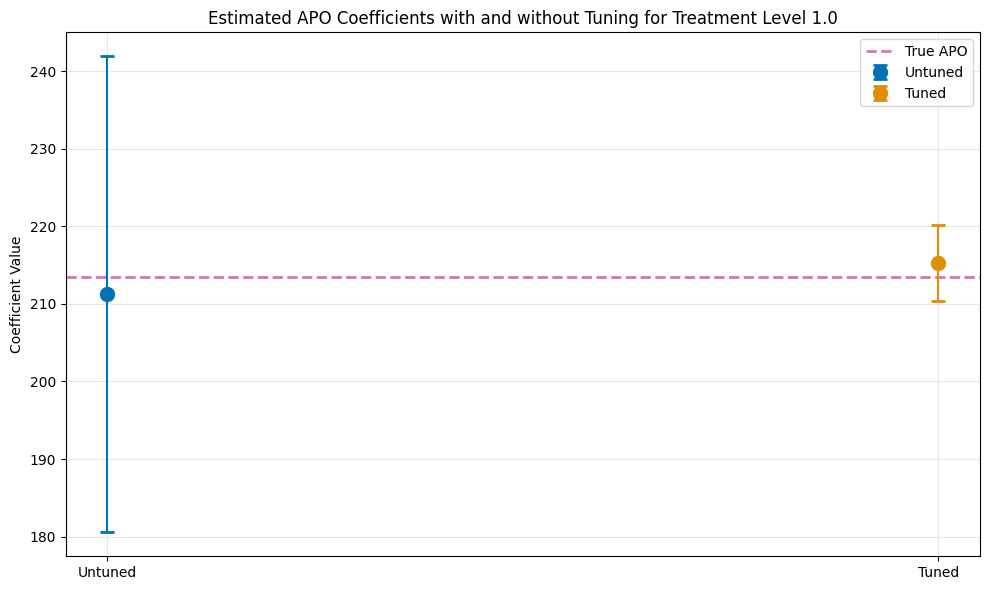

In [14]:
ci_untuned = dml_obj_untuned.confint()
ci_tuned = dml_obj_tuned.confint()

# Create comparison dataframe
comparison_data = {
    'Model': ['Untuned', 'Tuned'],
    'theta': [dml_obj_untuned.coef[0], dml_obj_tuned.coef[0]],
    'se': [dml_obj_untuned.se[0], dml_obj_tuned.se[0]],
    'ci_lower': [ci_untuned.iloc[0, 0], ci_tuned.iloc[0, 0]],
    'ci_upper': [ci_untuned.iloc[0, 1], ci_tuned.iloc[0, 1]]
}
df_comparison = pd.DataFrame(comparison_data)

print(f"\nTrue APO at treatment level {treatment_lvl}: {apos[int(treatment_lvl)]:.4f}\n")
print(df_comparison.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.errorbar(0, df_comparison.loc[0, 'theta'], 
             yerr=[[df_comparison.loc[0, 'theta'] - df_comparison.loc[0, 'ci_lower']], 
                   [df_comparison.loc[0, 'ci_upper'] - df_comparison.loc[0, 'theta']]], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[0], color=palette[0], 
             label='Untuned', markersize=10, zorder=2)
plt.errorbar(1, df_comparison.loc[1, 'theta'], 
             yerr=[[df_comparison.loc[1, 'theta'] - df_comparison.loc[1, 'ci_lower']], 
                   [df_comparison.loc[1, 'ci_upper'] - df_comparison.loc[1, 'theta']]], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[1], 
             label='Tuned', markersize=10, zorder=2)
plt.axhline(y=apos[int(treatment_lvl)], color=palette[4], linestyle='--', 
            linewidth=2, label='True APO', zorder=1)

plt.title(f'Estimated APO Coefficients with and without Tuning for Treatment Level {treatment_lvl}')
plt.ylabel('Coefficient Value')
plt.xticks([0, 1], ['Untuned', 'Tuned'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Hyperparameter Tuning Guide

In this section, we explore tuning options in more detail and employ a more complicated learning pipeline.

### Define Nuisance Learners

For our example, we will choose [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline) to generate a complex [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) or [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

In [15]:
base_regressors = [
    ('linear_regression', LinearRegression()),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1))
]

stacking_regressor = StackingRegressor(
    estimators=base_regressors,
    final_estimator=Ridge()
)

ml_g_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('stacking', stacking_regressor)
])
ml_g_pipeline

Pipeline(steps=[('scaler', RobustScaler()),
                ('stacking',
                 StackingRegressor(estimators=[('linear_regression',
                                                LinearRegression()),
                                               ('lgbm',
                                                LGBMRegressor(random_state=42,
                                                              verbose=-1))],
                                   final_estimator=Ridge()))])

In [16]:
base_classifiers = [
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42, verbose=-1))
]

stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(),
)

ml_m_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('stacking', stacking_classifier)
])
ml_g_pipeline

Pipeline(steps=[('scaler', RobustScaler()),
                ('stacking',
                 StackingRegressor(estimators=[('linear_regression',
                                                LinearRegression()),
                                               ('lgbm',
                                                LGBMRegressor(random_state=42,
                                                              verbose=-1))],
                                   final_estimator=Ridge()))])

### Untuned Model with Pipeline

Now let us take a look at the standard workflow, focusing on a single treatment level and using default hyperparameters.

In [17]:
dml_obj_untuned_pipeline = DoubleMLAPO(
    dml_data,
    ml_g_pipeline,
    ml_m_pipeline,
    treatment_level=treatment_lvl,
)

dml_obj_untuned_pipeline.fit()
dml_obj_untuned_pipeline.summary

coef   std err          t  P>|t|       2.5 %      97.5 %
d  213.512885  2.335125  91.435306    0.0  208.936124  218.089647

### Hyperparameter Tuning with Pipelines

Now, let us take a look at more complex. Again, we will initialize a separate model to compare the results.

In [18]:
dml_obj_tuned_pipeline = DoubleMLAPO(
    dml_data,
    ml_g_pipeline,
    ml_m_pipeline,
    treatment_level=treatment_lvl,
)

As before the tuning input is a parameter space dictionary for the hyperparameters for each learner that should be tuned.
This dictionary should include a callable for each learner you want to have (only a subset is also possible, i.e. only tuning `ml_g`).

Since we have now a much more complicated learner the tuning inputs have to passed correctly into the pipeline.

In [19]:
# parameter space for the outcome regression tuning
def ml_g_params_pipeline(trial):
    return {
        'stacking__lgbm__n_estimators': 100,
        'stacking__lgbm__learning_rate': trial.suggest_float('stacking__lgbm__learning_rate', 0.001, 0.1, log=True),
        'stacking__lgbm__max_depth': 5,
        'stacking__lgbm__min_child_samples': trial.suggest_int('stacking__lgbm__min_child_samples', 20, 50, step=10),
        'stacking__lgbm__lambda_l1': trial.suggest_float('stacking__lgbm__lambda_l1', 1e-3, 10.0, log=True),
        'stacking__lgbm__lambda_l2': trial.suggest_float('stacking__lgbm__lambda_l2', 1e-3, 10.0, log=True),
        'stacking__final_estimator__alpha': trial.suggest_float('stacking__final_estimator__alpha', 0.001, 10.0, log=True),
    }

# parameter space for the propensity score tuning
def ml_m_params_pipeline(trial):
    return {
        'stacking__lgbm__n_estimators': 100,
        'stacking__lgbm__learning_rate': trial.suggest_float('stacking__lgbm__learning_rate', 0.001, 0.1, log=True),
        'stacking__lgbm__max_depth': 5,
        'stacking__lgbm__min_child_samples': trial.suggest_int('stacking__lgbm__min_child_samples', 20, 50, step=10),
        'stacking__lgbm__lambda_l1': trial.suggest_float('stacking__lgbm__lambda_l1', 1e-3, 10.0, log=True),
        'stacking__lgbm__lambda_l2': trial.suggest_float('stacking__lgbm__lambda_l2', 1e-3, 10.0, log=True),
        'stacking__final_estimator__C': trial.suggest_float('stacking__final_estimator__C', 0.01, 100.0, log=True),
        'stacking__final_estimator__max_iter': 1000,
    }

param_space_pipeline = {
    'ml_g': ml_g_params_pipeline,
    'ml_m': ml_m_params_pipeline
}

As before, we can pass the arguments for optuna via `optuna_settings`.  For possible option please take a look at the [Optuna Documenation](https://optuna.readthedocs.io/en/stable/index.html). For each learner you can pass local settings which will override the settings.

Here, we will reduce the number of trials for `ml_g` as it did already perform quite well before.
In principle, we could also use different [samplers](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html), but generally we recommend to use the [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html), which is used by default.

In [20]:
optuna_settings_pipeline = {
    'n_trials': 200,
    'show_progress_bar': True,
    'verbosity': optuna.logging.WARNING,  # Suppress Optuna logs
    'ml_g': {
        'n_trials': 100
    }
}

As before, we can tune the hyperparameters via the `tune_ml_models()` method. If we would like to inspect the optuna.study results, we can return all tuning results via the `return_tune_res` argument.

We will have a detailed look at the returned results later in the notebook.

In [21]:
tuning_results = dml_obj_tuned_pipeline.tune_ml_models(
    ml_param_space=param_space_pipeline,
    optuna_settings=optuna_settings_pipeline,
    return_tune_res=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
dml_obj_tuned_pipeline.fit()
dml_obj_tuned_pipeline.summary

coef   std err          t  P>|t|       2.5 %      97.5 %
d  213.86343  2.276774  93.932651    0.0  209.401035  218.325825

**Remark**: All settings (`optuna_settings` and `ml_param_space`) can also be set on the `params_names` level instead of the `learner_names` level, i.e. `ml_g_d_lvl1` instead of `ml_g`. Generally, more specific settings will override more general settings.

### Comparison


True APO at treatment level 1.0: 213.4904

           Model      theta        se   ci_lower   ci_upper
         Untuned 211.232659 15.657431 180.544657 241.920661
           Tuned 215.273433  2.485000 210.402924 220.143943
Untuned Pipeline 213.512885  2.335125 208.936124 218.089647
  Tuned Pipeline 213.863430  2.276774 209.401035 218.325825


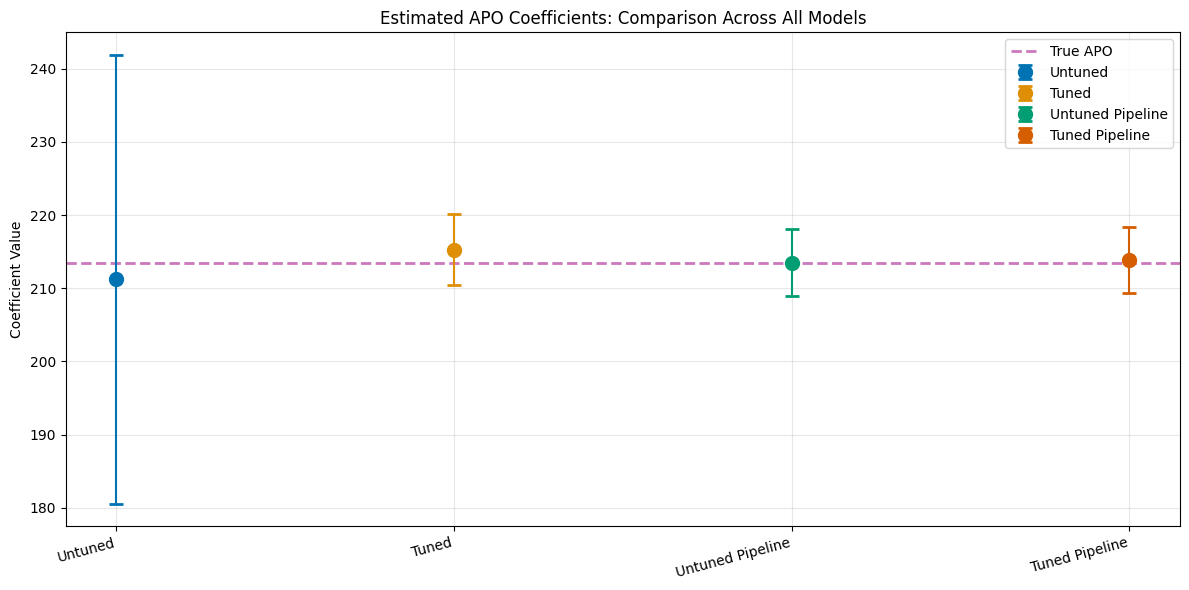

In [23]:
ci_untuned = dml_obj_untuned.confint()
ci_tuned = dml_obj_tuned.confint()
ci_untuned_pipeline = dml_obj_untuned_pipeline.confint()
ci_tuned_pipeline = dml_obj_tuned_pipeline.confint()

# Create comparison dataframe
comparison_data = {
    'Model': ['Untuned', 'Tuned', 'Untuned Pipeline', 'Tuned Pipeline'],
    'theta': [dml_obj_untuned.coef[0], dml_obj_tuned.coef[0], dml_obj_untuned_pipeline.coef[0], dml_obj_tuned_pipeline.coef[0]],
    'se': [dml_obj_untuned.se[0], dml_obj_tuned.se[0], dml_obj_untuned_pipeline.se[0], dml_obj_tuned_pipeline.se[0]],
    'ci_lower': [ci_untuned.iloc[0, 0], ci_tuned.iloc[0, 0], 
                 ci_untuned_pipeline.iloc[0, 0], ci_tuned_pipeline.iloc[0, 0]],
    'ci_upper': [ci_untuned.iloc[0, 1], ci_tuned.iloc[0, 1],
                 ci_untuned_pipeline.iloc[0, 1], ci_tuned_pipeline.iloc[0, 1]]
}
df_comparison = pd.DataFrame(comparison_data)

print(f"\nTrue APO at treatment level {treatment_lvl}: {apos[int(treatment_lvl)]:.4f}\n")
print(df_comparison.to_string(index=False))

# Create plot with all 4 models
plt.figure(figsize=(12, 6))

for i in range(len(df_comparison)):
    plt.errorbar(i, df_comparison.loc[i, 'theta'], 
                 yerr=[[df_comparison.loc[i, 'theta'] - df_comparison.loc[i, 'ci_lower']], 
                       [df_comparison.loc[i, 'ci_upper'] - df_comparison.loc[i, 'theta']]], 
                 fmt='o', capsize=5, capthick=2, ecolor=palette[i], color=palette[i], 
                 label=df_comparison.loc[i, 'Model'], markersize=10, zorder=2)

plt.axhline(y=apos[int(treatment_lvl)], color=palette[4], linestyle='--', 
            linewidth=2, label='True APO', zorder=1)

plt.title('Estimated APO Coefficients: Comparison Across All Models')
plt.ylabel('Coefficient Value')
plt.xticks(range(4), df_comparison['Model'], rotation=15, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detailed Tuning Result Analysis

The `tune_ml_models()` method creates several [Optuna Studies](https://optuna.readthedocs.io/en/stable/reference/study.html), which can be inspected in detail via the returned results.

The results are a list of dictionaries, which contain a corresponding `DMLOptunaResult` for each treatment variable on the `param_names` level, i.e. for each [Optuna Study](https://optuna.readthedocs.io/en/stable/reference/study.html) object a separate `DMLOptunaResult` is constructed.

In [24]:
# Optuna results for the single treatment
print(tuning_results[0].keys())

dict_keys(['ml_g_d_lvl0', 'ml_g_d_lvl1', 'ml_m'])


In this example, we take a more detailed look in the tuning of `ml_m`

In [25]:
print(tuning_results[0]['ml_m'])

================== DMLOptunaResult ==================
Learner name: ml_m
Params name: ml_m
Tuned: True
Best score: -0.5210215656500876
Scoring method: neg_log_loss

------------------ Best parameters    ------------------
{'stacking__final_estimator__C': 99.9143065172164,
 'stacking__lgbm__lambda_l1': 9.771463014326052,
 'stacking__lgbm__lambda_l2': 0.0013978426220758982,
 'stacking__lgbm__learning_rate': 0.0011563701553192595,
 'stacking__lgbm__min_child_samples': 30}



As we have access to the saved [Optuna Study](https://optuna.readthedocs.io/en/stable/reference/study.html) object, it is possible to access all trials and hyperparameter combinations

In [26]:
ml_m_study = tuning_results[0]['ml_m'].study
ml_m_study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0 -0.528553 2025-11-26 15:53:57.489511 2025-11-26 15:53:57.890548   
1         1 -0.523453 2025-11-26 15:53:57.891547 2025-11-26 15:53:58.267444   
2         2 -0.528991 2025-11-26 15:53:58.268406 2025-11-26 15:53:58.600445   
3         3 -0.521994 2025-11-26 15:53:58.601158 2025-11-26 15:53:58.929636   
4         4 -0.528075 2025-11-26 15:53:58.930497 2025-11-26 15:53:59.343117   
..      ...       ...                        ...                        ...   
195     195 -0.521644 2025-11-26 15:55:14.129881 2025-11-26 15:55:14.449172   
196     196 -0.521990 2025-11-26 15:55:14.449715 2025-11-26 15:55:14.810118   
197     197 -0.521118 2025-11-26 15:55:14.810960 2025-11-26 15:55:15.111526   
198     198 -0.525316 2025-11-26 15:55:15.112415 2025-11-26 15:55:15.543287   
199     199 -0.521044 2025-11-26 15:55:15.544058 2025-11-26 15:55:15.826366   

                  duration  params_stacking__final_estimator__C  \
0   0 days 00:00:00.401037                             0.037301   
1   0 days 00:00:00.375897                            24.451158   
2   0 days 00:00:00.332039                             0.014914   
3   0 days 00:00:00.328478                            43.646318   
4   0 days 00:00:00.412620                             0.235419   
..                     ...                                  ...   
195 0 days 00:00:00.319291                            97.760868   
196 0 days 00:00:00.360403                            99.447375   
197 0 days 00:00:00.300566                            99.675451   
198 0 days 00:00:00.430872                            99.982456   
199 0 days 00:00:00.282308                            80.453189   

     params_stacking__lgbm__lambda_l1  params_stacking__lgbm__lambda_l2  \
0                            0.498575                          0.001738   
1                            2.007596                          0.013849   
2                            1.540299                          0.242604   
3                            7.867187                          0.004868   
4                            0.636639                          6.249970   
..                                ...                               ...   
195                          7.085697                          0.001097   
196                          6.005734                          0.001353   
197                          7.589184                          0.001779   
198                          0.016786                          0.001159   
199                          9.930357                          0.001576   

     params_stacking__lgbm__learning_rate  \
0                                0.060706   
1                                0.065453   
2                                0.030858   
3                                0.010726   
4                                0.014593   
..                                    ...   
195                              0.001008   
196                              0.001181   
197                              0.001080   
198                              0.001184   
199                              0.001073   

     params_stacking__lgbm__min_child_samples     state  
0                                          30  COMPLETE  
1                                          50  COMPLETE  
2                                          40  COMPLETE  
3                                          20  COMPLETE  
4                                          30  COMPLETE  
..                                        ...       ...  
195                                        30  COMPLETE  
196                                        30  COMPLETE  
197                                        30  COMPLETE  
198                                        30  COMPLETE  
199                                        30  COMPLETE  

[200 rows x 11 columns]

 Additionally, we can access all [Optuna visualization options](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html)

In [27]:
fig = optuna.visualization.plot_optimization_history(ml_m_study)
show(fig)

In [28]:
fig = optuna.visualization.plot_parallel_coordinate(ml_m_study)
show(fig)

In [29]:
fig = optuna.visualization.plot_param_importances(ml_m_study)
show(fig)

## `DoubleMLAPOS` Tuning Example

We will repeat the tuning procedure for all treatment level with the `DoubleMLAPOS` object.
Combined `DoubleML` object, such as `DoubleMLAPOS` or `DoubleMLDIDMulti` just pass the tuning arguments to the underlying submodels.

In [30]:
treatment_lvls = np.unique(d)
print(treatment_lvls)

[0. 1. 2. 3.]


Consequently, we are tuning $3$ learners for each treatment level.

### Untuned Model

Again, let's start with the untuned model. We will focus on just on the boosted trees to highlight the ideas.

In [31]:
dml_apos_untuned = DoubleMLAPOS(
    dml_data,
    ml_g,
    ml_m,
    treatment_levels=treatment_lvls,
)
dml_apos_untuned.fit()
dml_apos_untuned.summary

coef    std err          t  P>|t|       2.5 %      97.5 %
0.0  199.244627   9.335496  21.342693    0.0  180.947391  217.541863
1.0  206.488551  10.468016  19.725662    0.0  185.971617  227.005485
2.0  210.440867   9.128061  23.054279    0.0  192.550196  228.331538
3.0  236.296077  19.486692  12.126023    0.0  198.102863  274.489292

### Hyperparameter Tuning

Let's initialize a second `DoubleMLAPOS` object.

In [32]:
dml_apos_tuned = DoubleMLAPOS(
    dml_data,
    ml_g,
    ml_m,
    treatment_levels=treatment_lvls,
)

Again, we can directly call the `tune_ml_models()` method for tuning. This will take some time as each submodel is tuned.

In [33]:
dml_apos_tuned.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings_pipeline,
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Afterwards, all hyperparameters are set for each submodel and we can proceed as usual.

In [34]:
dml_apos_tuned.fit()
dml_apos_tuned.summary

coef   std err          t  P>|t|       2.5 %      97.5 %
0.0  211.422244  2.233931  94.641355    0.0  207.043820  215.800668
1.0  215.370889  2.581675  83.422933    0.0  210.310899  220.430878
2.0  219.233573  2.243180  97.733404    0.0  214.837022  223.630124
3.0  215.927956  2.442976  88.387268    0.0  211.139811  220.716100

In [35]:
dml_apos_tuned.causal_contrast(reference_levels=[0]).summary

coef   std err         t     P>|t|     2.5 %     97.5 %
1.0 vs 0.0  3.948644  2.615180  1.509894  0.131071 -1.177015   9.074303
2.0 vs 0.0  7.811329  2.375106  3.288833  0.001006  3.156205  12.466452
3.0 vs 0.0  4.505712  2.579080  1.747023  0.080633 -0.549192   9.560616

Finally, lets compare the estimates including confidence intervals.

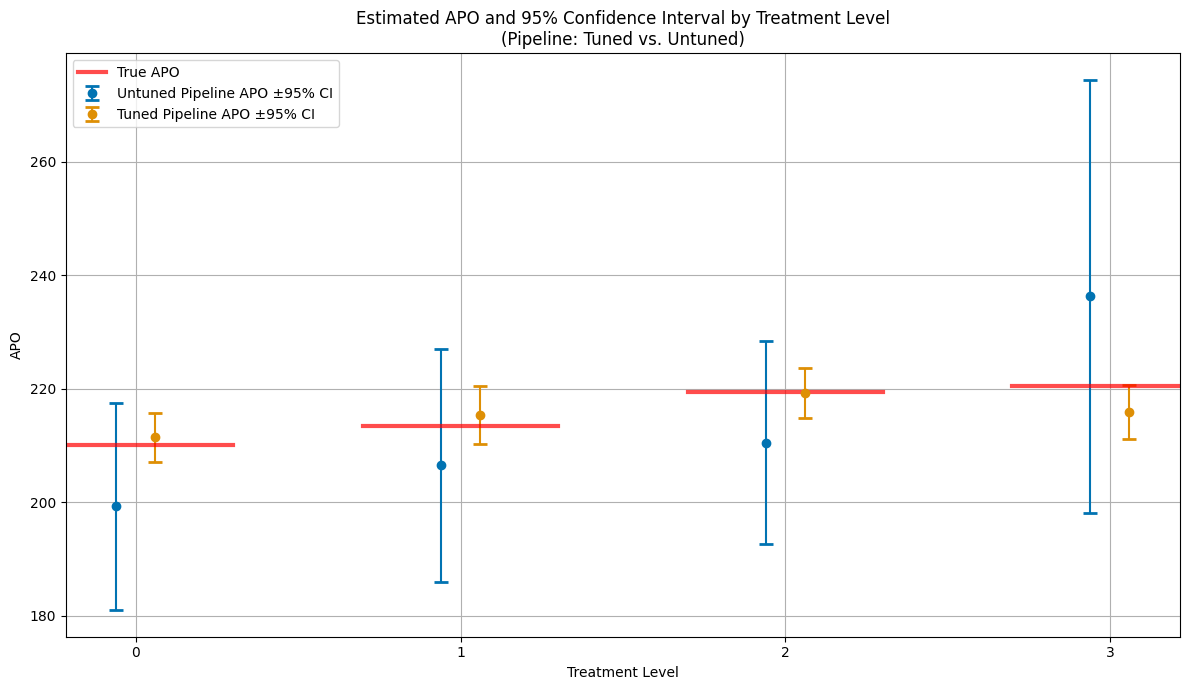

In [36]:
# --- Plot APOs and 95% CIs for all treatment levels (tuned vs. untuned pipeline) ---

plt.figure(figsize=(12, 7))
palette = sns.color_palette("colorblind")

# Collect results for each treatment level from both models
treatment_levels_plot = np.unique(d)
n_levels = len(treatment_levels_plot)

# Prepare DataFrame for plotting
df_apo_plot = pd.DataFrame({
    'treatment_level': np.tile(treatment_levels_plot, 2),
    'APO': np.concatenate([dml_apos_untuned.coef, dml_apos_tuned.coef]),
    'ci_lower': np.concatenate([dml_apos_untuned.confint().iloc[:, 0], dml_apos_tuned.confint().iloc[:, 0]]),
    'ci_upper': np.concatenate([dml_apos_untuned.confint().iloc[:, 1], dml_apos_tuned.confint().iloc[:, 1]]),
    'Model': ['Untuned Pipeline'] * n_levels + ['Tuned Pipeline'] * n_levels
})

jitter_strength = 0.12
models = df_apo_plot['Model'].unique()
n_models = len(models)

for i, model in enumerate(models):
    df = df_apo_plot[df_apo_plot['Model'] == model]
    jitter = (i - (n_models - 1) / 2) * jitter_strength
    x_jittered = df['treatment_level'] + jitter
    plt.errorbar(
        x_jittered,
        df['APO'],
        yerr=[df['APO'] - df['ci_lower'], df['ci_upper'] - df['APO']],
        fmt='o',
        capsize=5,
        capthick=2,
        ecolor=palette[i % len(palette)],
        color=palette[i % len(palette)],
        label=f"{model} APO ±95% CI",
        zorder=2
    )

# Add true APOs as horizontal lines
x_range = plt.xlim()
total_width = x_range[1] - x_range[0]
for i, level in enumerate(treatment_levels_plot):
    line_width = 0.6
    x_center = level
    x_start = x_center - line_width/2
    x_end = x_center + line_width/2
    xmin_rel = max(0, (x_start - x_range[0]) / total_width)
    xmax_rel = min(1, (x_end - x_range[0]) / total_width)
    plt.axhline(y=apos[int(level)], color='red', linestyle='-', alpha=0.7,
                xmin=xmin_rel, xmax=xmax_rel,
                linewidth=3, label='True APO' if i == 0 else "")

plt.title('Estimated APO and 95% Confidence Interval by Treatment Level\n(Pipeline: Tuned vs. Untuned)')
plt.xlabel('Treatment Level')
plt.ylabel('APO')
plt.xticks(treatment_levels_plot)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()